In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

# import synoptic
# import herbie
import metpy
import xarray as xr

from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import cartopy.crs as ccrs

In [2]:
# Determine case study dates
dt = "2024-12-20 18:00"
fxx = 1

In [3]:
# Function for loading HRRR data
def load_hrrr_data():
    """Load HRRR data.
    """
    H = Herbie(
        dt,
        model="hrrr",
        product="nat",
        # product="sfc",
        fxx=fxx,
        )

    return H

def visualise_cross_section():
    """Visualise a cross section of the HRRR data.
    """
    pass

def load_observation_data():
    """Load observation data.

    KVEL, UTxxx, COOP, etc. See Alex's original email
    """
    pass

def load_clyfar_forecasts():
    """Load ClyFar forecasts.
    """
    pass

def download_rtma():
    """Download RTMA data.
    """
    pass

def plot_available_stations():
    """Plot available stations.
    """
    pass

def filter_time_series():
    """Filter time series, especially snow.
    """
    pass

def mask_by_elevation():
    """Mask data by elevation.
    """
    pass

def get_CONUS(qstr, herbie_inst, remove_grib=False):
    ds = herbie_inst.xarray(qstr, remove_grib=remove_grib, decode_timedelta=True)
    print(ds)
    variables = [i for i in list(ds) if len(ds[i].dims) > 0]
    ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()
    return ds.reset_coords(["time", "step", "valid_time"], drop=True)

def get_closest_point(ds,vrbl,lat,lon):
    grid_crs = ds[vrbl].metpy.cartopy_crs
    latlon_crs = ccrs.PlateCarree(globe=ds[vrbl].metpy.cartopy_globe)
    x_t, y_t = grid_crs.transform_point(lon, lat, src_crs=latlon_crs)
    return ds[vrbl].sel(x=x_t,y=y_t,method="nearest")

def crop_to_UB(ds,):
    # ds = ds.rename({'x':'west_east','y':'south_north'})

    sw_corner = (39.4, -110.9)
    ne_corner = (41.1, -108.5)
    lats = ds.latitude.values
    lons = ds.longitude.values

    if np.max(lons) > 180.0:
        lons -= 360.0

    crop = xr.DataArray(np.logical_and(np.logical_and(lats>sw_corner[0],
                                                          lats<ne_corner[0]),np.logical_and(lons>sw_corner[1],lons<ne_corner[1])),
                            # dims=['south_north','west_east'])
                            dims = ['y','x'])
    return ds.where(crop,drop=True)


In [4]:
H = load_hrrr_data()

# Show available products
H.PRODUCTS



✅ Found ┊ model=hrrr ┊ product=nat ┊ 2024-Dec-20 18:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws


{'sfc': '2D surface level fields; 3-km resolution',
 'prs': '3D pressure level fields; 3-km resolution',
 'nat': 'Native level fields; 3-km resolution',
 'subh': 'Subhourly grids; 3-km resolution'}

In [5]:
print(H.SOURCES)

{'aws': 'https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20241220/conus/hrrr.t18z.wrfnatf01.grib2', 'nomads': 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/hrrr/prod/hrrr.20241220/conus/hrrr.t18z.wrfnatf01.grib2', 'google': 'https://storage.googleapis.com/high-resolution-rapid-refresh/hrrr.20241220/conus/hrrr.t18z.wrfnatf01.grib2', 'azure': 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20241220/conus/hrrr.t18z.wrfnatf01.grib2', 'pando': 'https://pando-rgw01.chpc.utah.edu/hrrr/nat/20241220/hrrr.t18z.wrfnatf01.grib2', 'pando2': 'https://pando-rgw02.chpc.utah.edu/hrrr/nat/20241220/hrrr.t18z.wrfnatf01.grib2'}


In [6]:
ds = H.xarray("TMP:2 m above", decode_timedelta=True)
ds

/Users/johnlawson/anaconda3/envs/brc-tools/lib/python3.12/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/Users/johnlawson/anaconda3/envs/brc-tools/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-12-20T18:00:00
    step                 timedelta64[ns] 8B 01:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB ...
    longitude            (y, x) float64 15MB ...
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/johnlawson/data/hrrr/20241220/subset_6ce4...
    search:                  TMP:2 m above

Text(1.0, 1.0, '2 metre temperature')

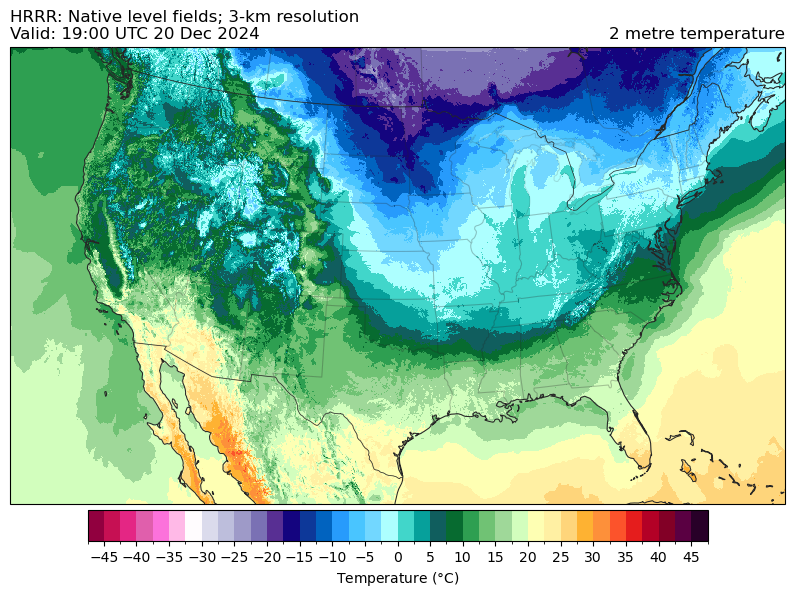

In [7]:
ax = EasyMap("50m", crs=ds.herbie.crs, figsize=(10, 8)).BORDERS().STATES().ax

p = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m - 273.15,
    transform=pc,
    **paint.NWSTemperature.kwargs2,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    **paint.NWSTemperature.cbar_kwargs2,
)

ax.set_title(
    f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds.t2m.GRIB_name, loc="right")

In [8]:
# Use metpy for cross-sections
print(ds)

<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-12-20T18:00:00
    step                 timedelta64[ns] 8B 01:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2024-12-20T19:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 292.8 292.8 292.8 ... 270.5 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:            

In [9]:
H = load_hrrr_data()
ds_t2m = get_CONUS("TMP:2 m", H, remove_grib=False)
ds_t2m_crop = crop_to_UB(ds_t2m) # * 100
xs_ds = metpy.interpolate.cross_section(ds_t2m_crop, start=(35.5, -97.5), end=(35.5, -96.5))

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2024-Dec-20 18:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/anaconda3/envs/brc-tools/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_45649/1168274158.py:56: UserWarning: More than one time coordinate present for variable  "t2m".
  ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-12-20T18:00:00
    step                 timedelta64[ns] 8B 01:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB ...
    longitude            (y, x) float64 15MB ...
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws